In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_curve,roc_auc_score
from sklearn.preprocessing import OrdinalEncoder

df = pd.read_csv('./titanic.csv')
df_limpio=df.dropna()


In [2]:

def get_features_cat_regression(df, target_col, pvalue=0.05, cardinality_threshold=10):

    """
    Identifica columnas categóricas en un DataFrame que tienen una relación estadísticamente significativa
    con una columna objetivo numérica, utilizando T-Test para baja cardinalidad y Z-Test para alta cardinalidad.

    Argumentos:
    df (pd.DataFrame): El DataFrame que contiene los datos a analizar.
    target_col (str): El nombre de la columna objetivo numérica en el DataFrame.
    pvalue (float): El valor p umbral para determinar la significancia estadística.
    cardinality_threshold (int): El umbral de porcentaje para determinar alta cardinalidad en la columna objetivo.

    Retorna:
    list: Una lista de columnas categóricas que tienen una relación estadísticamente significativa con la columna objetivo.
    """
    
    if df.isnull().any().any():
        print("Advertencia: El DataFrame contiene valores NaN.")
        return None

    if target_col not in df.columns:
        print(f"La columna '{target_col}' no existe en el DataFrame.")
        return None

    if not pd.api.types.is_numeric_dtype(df[target_col]):
        print(f"La columna '{target_col}' debe ser numérica.")
        return None

    cardinality_percentage = df[target_col].nunique() / len(df) * 100
    if cardinality_percentage < cardinality_threshold:
        print(f"La columna '{target_col}' no tiene alta cardinalidad. Cardinalidad como porcentaje del total: {cardinality_percentage:.2f}%")
        return None

    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    significant_cols = []
    overall_mean = df[target_col].mean()

    for col in categorical_cols:
        unique_values = df[col].nunique()

        if unique_values > 1 and unique_values <= 30:
            for unique_value in df[col].unique():
                group = df[df[col] == unique_value][target_col].dropna()
                if group.var() == 0:  
                    continue  
                t_stat, p_val = stats.ttest_1samp(group, overall_mean, nan_policy='omit')
                if p_val < pvalue:
                    significant_cols.append(col)
                    break

        elif unique_values > 30:
            for unique_value in df[col].unique():
                subgroup = df[df[col] == unique_value][target_col]
                success_count = np.sum(subgroup > overall_mean)
                nobs = len(subgroup)

                if nobs == 0:  
                    continue

                z_stat, p_val = proportions_ztest(success_count, nobs, prop=0.5)
                if p_val < pvalue:
                    significant_cols.append(col)
                    break

    return significant_cols


In [3]:
def plot_features_cat_regression(df, target_col, columns=[], pvalue=0.05, with_individual_plot=False):
    """
    Genera histogramas agrupados de la variable target_col para cada uno de los valores de las variables
    categóricas en 'columns' que tienen una relación estadísticamente significativa con target_col,
    basado en un T-Test para baja cardinalidad y Z-Test para alta cardinalidad.
    
    Argumentos:
    df (pd.DataFrame): El DataFrame que contiene los datos a analizar.
    target_col (str): El nombre de la columna objetivo numérica en el DataFrame.
    columns (list): Lista de nombres de columnas categóricas a analizar. Si está vacía, se utilizarán todas las columnas categóricas.
    pvalue (float): El valor p umbral para determinar la significancia estadística.
    with_individual_plot (bool): Si es True, genera un histograma para cada columna categórica significativa.
    
    Retorna:
    list: Una lista de nombres de columnas categóricas que tienen una relación estadísticamente significativa con la columna objetivo.
    """
    

    if df.isnull().any().any():
        print("Advertencia: El DataFrame contiene valores NaN.")
        return None

    if not target_col or target_col not in df.columns:
        print("La columna target_col no está en el DataFrame o no se especificó correctamente.")
        return None

    if not pd.api.types.is_numeric_dtype(df[target_col]):
        print("La columna target_col debe ser numérica.")
        return None

    if not columns:
        columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    significant_cols = []

    for col in columns:
        if col not in df.columns:
            continue
        unique_values = df[col].nunique()

        if unique_values > 1:  
            for unique_value in df[col].unique():
                group = df[df[col] == unique_value][target_col].dropna()
                if group.var() == 0:  
                    continue
                if unique_values <= 30:  
                    t_stat, p_val = stats.ttest_1samp(group, df[target_col].mean(), nan_policy='omit')
                else:  
                    success_count = (group > df[target_col].mean()).sum()
                    nobs = len(group)
                    z_stat, p_val = stats.proportions_ztest(success_count, nobs, prop=0.5)

                if p_val < pvalue:
                    significant_cols.append(col)
                    break 
                
    if with_individual_plot and significant_cols:
        for col in significant_cols:
            if col in df.columns:
                df.groupby(col)[target_col].plot(kind='hist', alpha=0.5, legend=True, title=f"Histograma de '{target_col}' por '{col}'")
                plt.xlabel(target_col)
                plt.ylabel('Frecuencia')
                plt.legend(title=col)
                plt.show()

    return significant_cols


In [4]:
plot_features_cat_regression(df_limpio,"age",pvalue=0.01)

['class', 'who', 'deck', 'alive']

In [5]:
get_features_cat_regression(df_limpio,"age",pvalue=0.01)

['class', 'who', 'deck', 'alive']

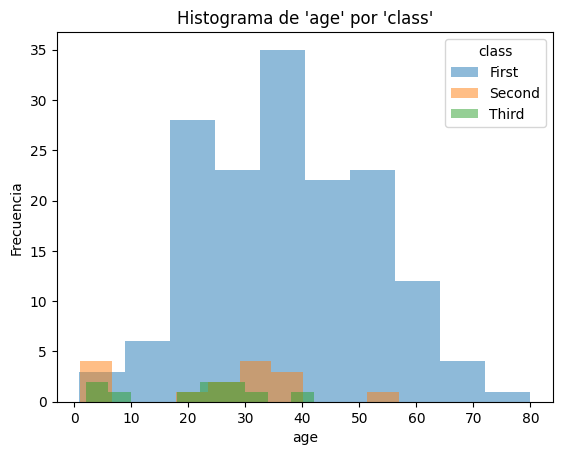

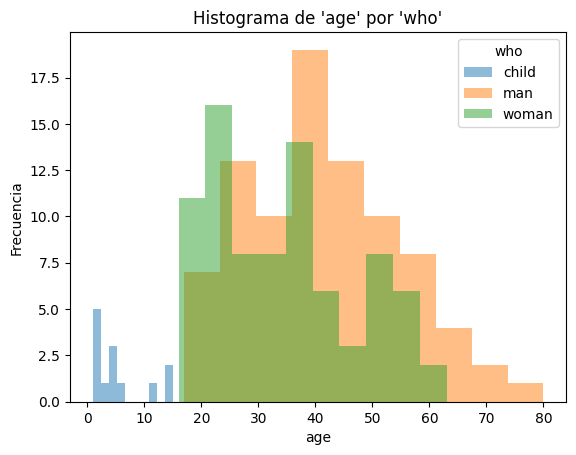

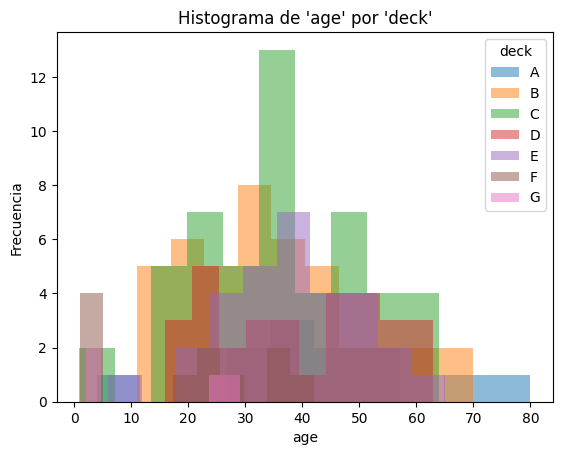

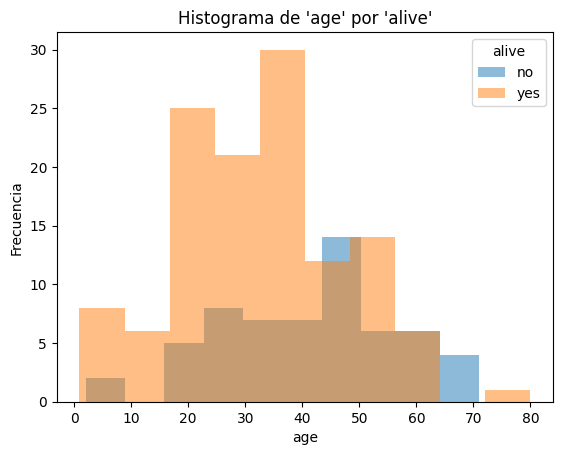

['class', 'who', 'deck', 'alive']

In [6]:
plot_features_cat_regression(df_limpio,"age",pvalue=0.01,with_individual_plot=True)